# Phase and group velocities
Calculate the phase and group velocities over a bathymetry grid. For actual propagation will need to define distributions around σ and θ for each grid cell, which makes calculating the velocities a bigger problem. Also need to know if need to recalculate at each time step.
Also need to decide what to do for land here.

In [2]:
import os
import numpy as np
import swan
import cmocean.cm as cmo
import matplotlib.pyplot as plt

indir = os.path.join('data_temp')

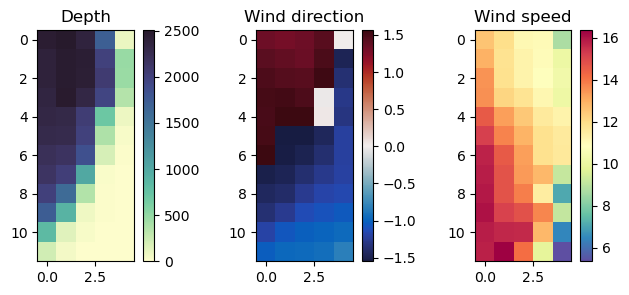

In [3]:
bathy = np.load(os.path.join(indir, 'bathymetry.npz'))['array']
direction = np.load(os.path.join(indir, 'direction.npz'))['array'] # taking wind direction as direction for now
speed = np.load(os.path.join(indir, 'speed.npz'))['array']
bathy[bathy < 0] = 0 # should be zero?

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
im = axs[0].imshow(bathy, cmap=cmo.deep)
plt.colorbar(im)
im = axs[1].imshow(direction, cmap=cmo.balance)
plt.colorbar(im)
im = axs[2].imshow(speed, cmap="Spectral_r")
plt.colorbar(im)

axs[0].set_title("Depth")
axs[1].set_title("Wind direction")
axs[2].set_title("Wind speed");

/Users/alison/Documents/DPhil/numerical-wave-models/swan/swan/relations.py:51: RuntimeWarning: invalid value encountered in true_divide
  n = (1 / 2) * (1 + (2 * l2(k) * d) / np.sinh(2 * l2(k) * d))


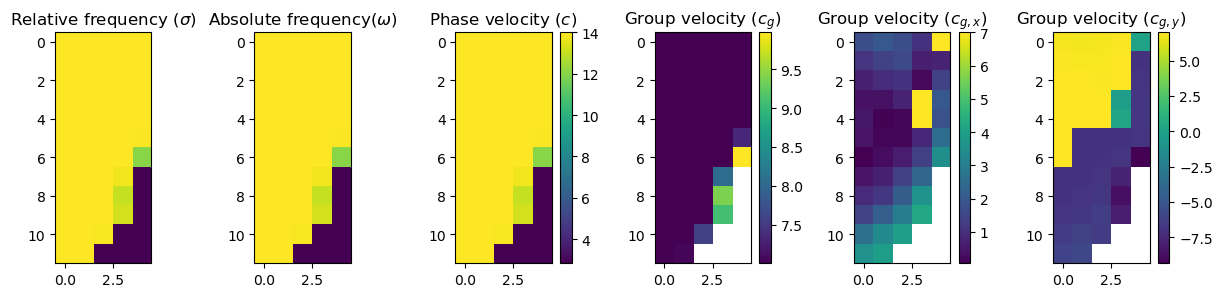

In [5]:
# geospatial velocities
u = swan.u + np.array([1, 3])
k = swan.k

σ = swan.relative_frequency(k, bathy)
ω = swan.absolute_frequency(σ, k, u)
c = swan.phase_speed(k, bathy, σ, u)
cg = swan.group_velocity(k, bathy, σ, u)
cx, cy = swan.spatial_group_velocity(cg, direction) # spatial propagation of wave energy in (x,y)

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(σ)
axs[1].imshow(ω)
im = axs[2].imshow(c)
plt.colorbar(im)
im = axs[3].imshow(cg)
plt.colorbar(im)
im = axs[4].imshow(cx)
plt.colorbar(im)
im = axs[5].imshow(cy)
plt.colorbar(im)

axs[0].set_title(r'Relative frequency ($\sigma$)')
axs[1].set_title(r'Absolute frequency($\omega$)')
axs[2].set_title(r'Phase velocity ($c$)')
axs[3].set_title(r'Group velocity ($c_g$)');
axs[4].set_title(r'Group velocity ($c_{g,x}$)');
axs[5].set_title(r'Group velocity ($c_{g,y}$)');

# Spectral velocities
## Refraction
Is this stationary in time?

$$c_\theta = \frac{\text{d} \theta}{\text{d} t} = \frac{c_g}{c}\left(\frac{\partial c}{\partial m}\right)$$

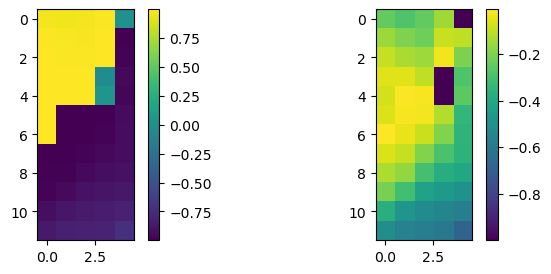

In [6]:
c = swan.phase_speed(k, bathy, σ, u)
cg = swan.group_velocity(k, bathy, σ, u)

ny, nx = c.shape
cg = cg.ravel()
c = c.ravel()
n = len(c)

fig, axs = plt.subplots(1, 2, figsize=(8,3))
im = axs[0].imshow(np.sin(direction))
plt.colorbar(im)
im = axs[1].imshow(-np.cos(direction))
plt.colorbar(im);

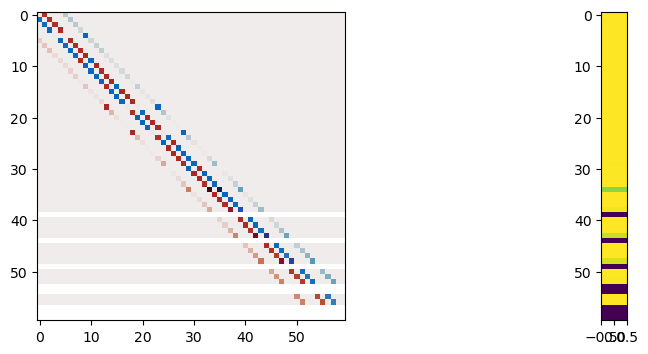

In [7]:
def d_dm_central_diff(direction, dx=1, dy=1):
    θ = direction.ravel()
    n = len(θ)
    left = np.diag((1 / (2 * dx)) * np.ones(n - 1), 1) - np.diag((1 / (2 * dx)) * np.ones(n - 1), -1)
    left = left * np.sin(θ)[:, np.newaxis]
    right = np.diag((1 / (2 * dy)) * np.ones(n - nx), nx) - np.diag((1 / (2 * dy)) * np.ones(n - nx), -nx)
    right *= np.cos(θ)[:, np.newaxis]
    A = left - right
    return A


def d_ds_central_diff(direction, dx=1, dy=1):
    θ = direction.ravel()
    n = len(θ)
    left = np.diag((1 / (2 * dx)) * np.ones(n - 1), 1) - np.diag((1 / (2 * dx)) * np.ones(n - 1), -1)
    left = left * np.cos(θ)[:, np.newaxis]
    right = np.diag((1 / (2 * dy)) * np.ones(n - nx), nx) - np.diag((1 / (2 * dy)) * np.ones(n - nx), -nx)
    right *= -np.sin(θ)[:, np.newaxis]
    A = left - right
    return A


A = d_dm_central_diff(direction)
A *= (cg / c)[:, np.newaxis]
cθ = A @ c

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(A, cmap=cmo.balance)
axs[1].imshow(c[:, np.newaxis], aspect=0.2);

## Effect of shifting frequencies

Equation (7.3.32) in Holthuijsen (2007) states,
$$ \frac{\text d \sigma}{\text d t} = c_\sigma = \frac{\partial \sigma}{\partial d} \left( \frac{\partial d}{\partial t} + U\frac{\partial d}{\partial s}  \right) - c_gk\frac{\partial U_n}{\partial m} $$

since depth is not changing

$$\frac{\text d \sigma}{\text d t} = c_\sigma = \frac{\partial \sigma}{\partial d} \left(U\frac{\partial d}{\partial s}  \right) - c_gk\frac{\partial U_n}{\partial m}.$$

Also 

$$ \frac{\partial}{\partial s} = \frac{\partial}{\partial x}\cos\theta - \frac{\partial}{\partial y}\sin\theta $$ and $$ \frac{\partial}{\partial m} = \frac{\partial}{\partial x}\sin\theta + \frac{\partial}{\partial y}\cos\theta. $$


In the term $U \frac{\partial d}{\partial s}$, $U$ is the magnitude of the current in the current's streamline $s$. In the SWAN documentation this is expressed $u \cdot \nabla_x d$ so these are equivalent. It's the change of $d$ in the direction of $U$ (i.e., $s$).

Similarly $c_gkU_n$, where $U_n$ and $k$ are the magnitudes of the current and wavenumber in the direction of the wave ray, is equivalent to $c_g\vec k \cdot \vec u$.

Let's build this up.

The first term is $$\frac{\partial \sigma}{\partial d}$$ which has an analytical solution.

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_171/4163976371.py:3: RuntimeWarning: invalid value encountered in true_divide
  first_term = σ / np.sinh(2 * l2(k) * bathy)


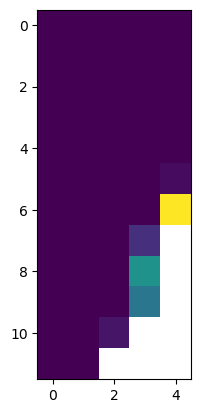

In [8]:
l2 = swan.l2

first_term = σ / np.sinh(2 * l2(k) * bathy)
plt.imshow(first_term)

The second term is $$\vec u \cdot \nabla_x d$$ 

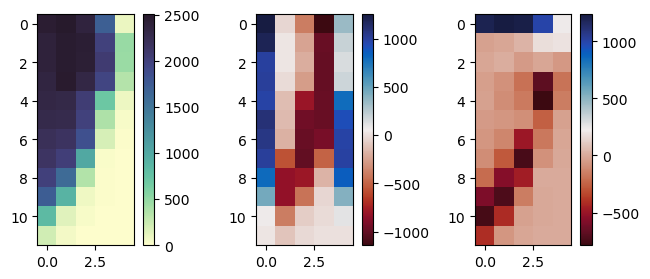

In [9]:
def central_diff(n, dx=1, step=1):
    left = np.diag(np.ones(n - step), step) 
    right = np.diag(np.ones(n - step), -step)
    A = (left - right) / (2 * dx)
    return A


n = len(bathy.ravel())
nabla_x = central_diff(n, step=1)
nabla_y = central_diff(n, step=nx)
bathy_gradx = nabla_x @ bathy.ravel()
bathy_grady = nabla_y @ bathy.ravel()

bathy_gradx = bathy_gradx.reshape([ny, nx])
bathy_grady = bathy_grady.reshape([ny, nx])

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
im = axs[0].imshow(bathy, cmap=cmo.deep)
plt.colorbar(im);
im = axs[1].imshow(bathy_gradx, cmap=cmo.balance_r)
plt.colorbar(im);
im = axs[2].imshow(bathy_grady, cmap=cmo.balance_r)
plt.colorbar(im);

In [10]:
bathy_grad = np.stack([bathy_gradx, bathy_grady], axis=0)

u[np.newaxis, ...].shape, bathy_grad.shape


((1, 2), (2, 12, 5))

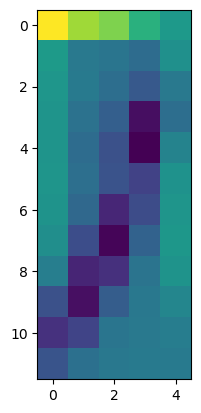

In [11]:
bathy_grad = np.stack([bathy_gradx, bathy_grady], axis=-1)
second_term = np.einsum('i,jki->jk', u, bathy_grad)
plt.imshow(second_term)

## Third term

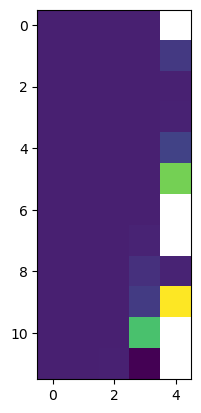

In [135]:
third_term = cg * (k @ u)
third_term  = third_term.reshape([ny, nx])
plt.imshow(third_term)

### Final $c_\sigma$

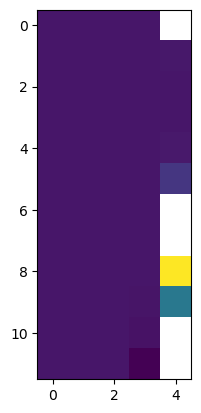

In [139]:
cσ = first_term * second_term - third_term
plt.imshow(cσ)

In [140]:
cσ

array([[  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
                  nan],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
           3.69734428],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
          -1.51193667],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
          -1.3983103 ],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
           5.98218537],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
         110.87001078],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -1.55550982,
                  nan],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -2.07103491,
                  nan],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -3.406872  ,
        1075.50156194],
       [  -1.55550982,   -1.55550982,   -1.55550982,   -3.44469197,
         387.47813189],
       [  -1.55550982,   -1.55550982,   -1.55550983,  -14.83866697,
            